## 1. Load voxel model and preview

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Taichi] Starting on arch=cuda
Loaded Voxel shape: (128, 128, 128)  from: ./assets/bun_zipper_res3.ply
Number of filled voxels: 54575
Loaded Voxel shape: (128, 128, 128)  from: ./assets/wine_glass.obj
Number of filled voxels: 37518
Floor Ratio: -0.9 , Floor Height: 6


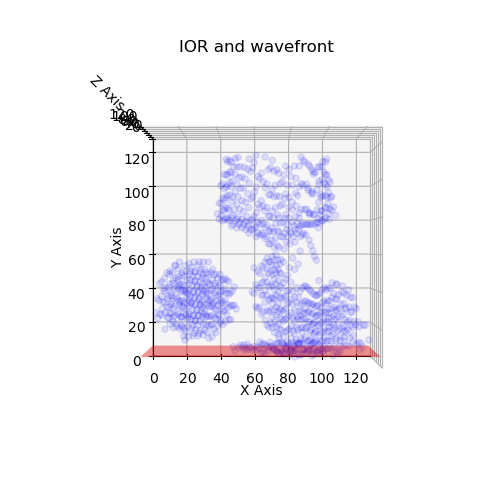

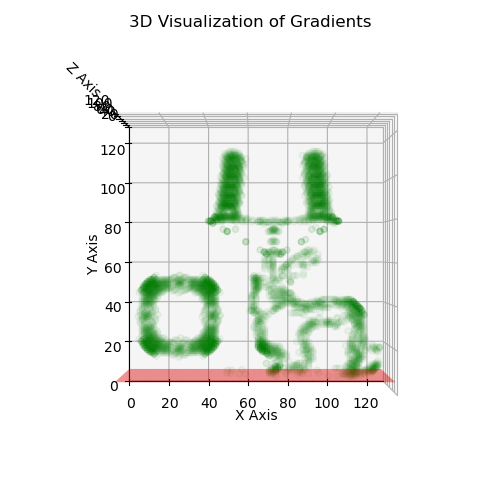

In [33]:
from setup.voxel_setup import setup_voxel_scene, NUM_XYZ
from common.plot import Plotter
from simulation.simulator import get_irrad_loc_dir, compute_ior_gradient
from simulation.simulate_utils import remove_under_floor

import taichi as ti
from scipy import ndimage

%load_ext autoreload
%autoreload 2
# May comment it because the compatibility of this extension is not good
%matplotlib widget 

# debug=True to check boundary access
ti.init(arch=ti.gpu)
scene, floor_height = setup_voxel_scene()

sampler_multiplier = 7
to_load_save = True
plotter = Plotter(sampler_multiplier, floor_height)

scene.ior = ndimage.gaussian_filter(scene.ior, sigma=3.0, radius=1)
scene.gradient = compute_ior_gradient(scene.ior)

plotter.plot_wavefront(scene.ior, pos=None, dir=None)
plotter.plot_gradient(scene.gradient, threshold=0.2)

## 2. Perform light simulation

In [34]:
scene.irradiance, scene.local_diretion = get_irrad_loc_dir(scene, sampler_multiplier, 
                                                           to_load_save=to_load_save, 
                                                           plotter=plotter,
                                                           num_show_images=3)
scene.ior = remove_under_floor(scene.ior, floor_height)

[ Loaded ] irradiance and local direction from c:\Users\yaozi\Desktop\Voxel-Render\data\saves\NP(irrad,loc_dir)(7-samplers).npz


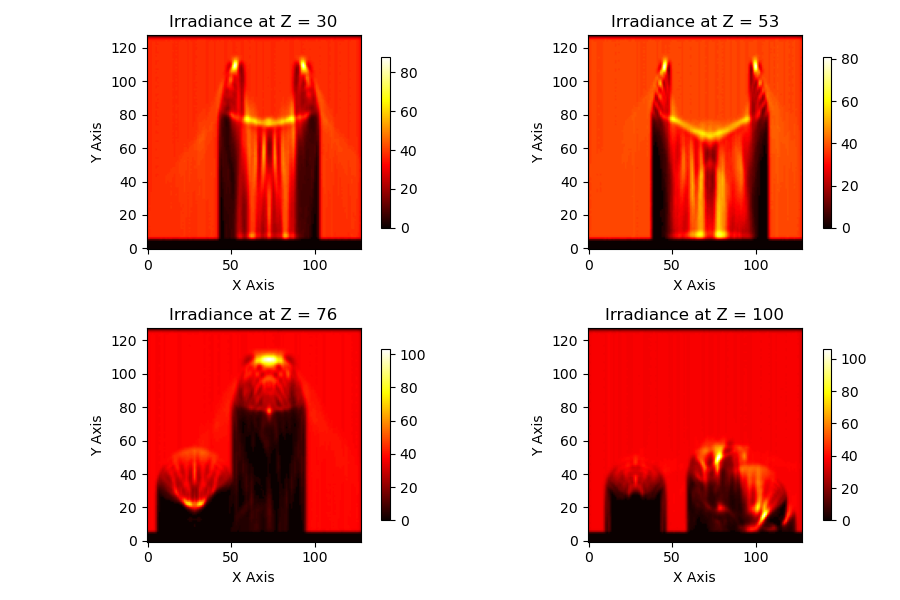

In [35]:
# plotter.plot_irradiance_grid(scene.irradiance)
plotter.plot_irradiance_slices(scene.irradiance, num_slices=4, z_start=30, z_end=100)
# plotter.plot_local_direction_grid_slices(scene.local_diretion[:, floor_height:, :], num_slices=4, z_start=30, z_end=100)

## 3. Ray marching render

In [36]:
scene.display()


* Drag with your left mouse button to rotate camera
* Press W/A/S/D/Q/E to move camera



## 4. Different data structures to store or fit irradiance

In [37]:
from data.siren import SirenFitter, siren_post_process
from data.mlp import MLP, mlp_post_process
from data.octree import Octree

### 4.1 SIREN to fit irradiance

In [38]:
siren_fitter= SirenFitter(scene.irradiance, floor_height, sampler_multiplier,
                     hidden_features=256, hidden_layers=3, omega=24)
siren_fitter.fit(total_epochs=24, batch_size=20000, lr=5e-4)

[ Loaded ] SIREN model from "SIREN(Irrad)(7-samplers)(24-epoches)(24 omega).pt"


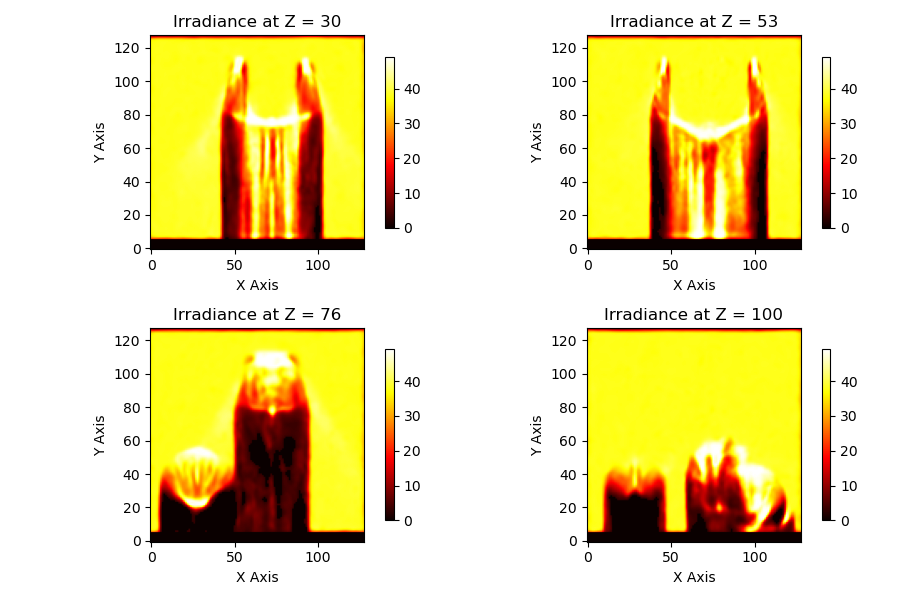

(128, 128, 128)

In [39]:
siren_res = siren_fitter.infer()
plotter.plot_irradiance_slices(siren_res, threshold=3, num_slices=4, z_start=30, z_end=100)
siren_res.shape

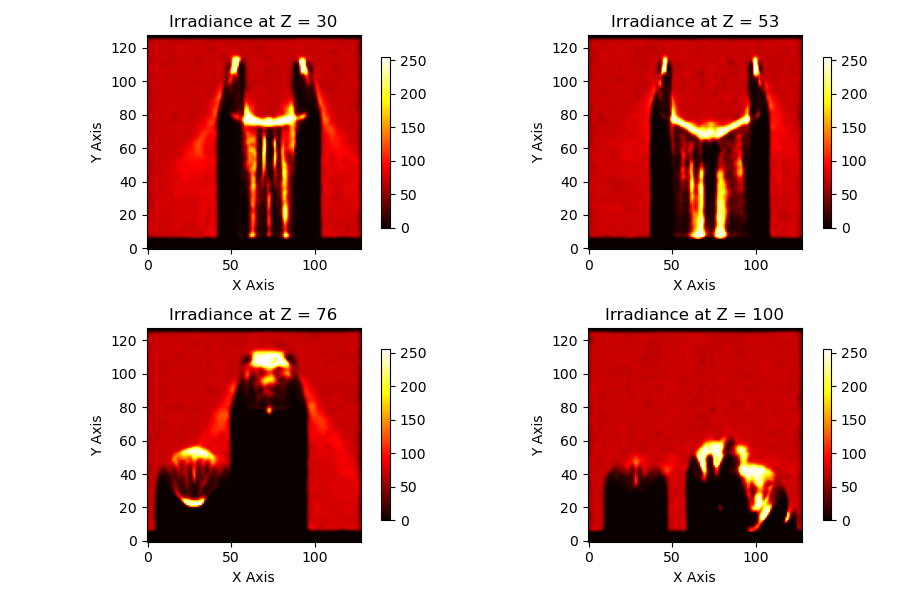

In [40]:
corrected_siren_res = siren_post_process(siren_res, gamma=0.2)
plotter.plot_irradiance_slices(corrected_siren_res, threshold=3, num_slices=4, z_start=30, z_end=100)

### 4.2 MLP to fit irradiance

In [41]:
mlp = MLP(scene.irradiance, floor_height, NUM_XYZ, sampler_multiplier, num_epoches=150)

Inputs shape: (1998848, 3) ; Targets shape: torch.Size([1998848])
[ Loaded ] model from "MLP(Irrad)(7-samplers)(150-epoches).pt"


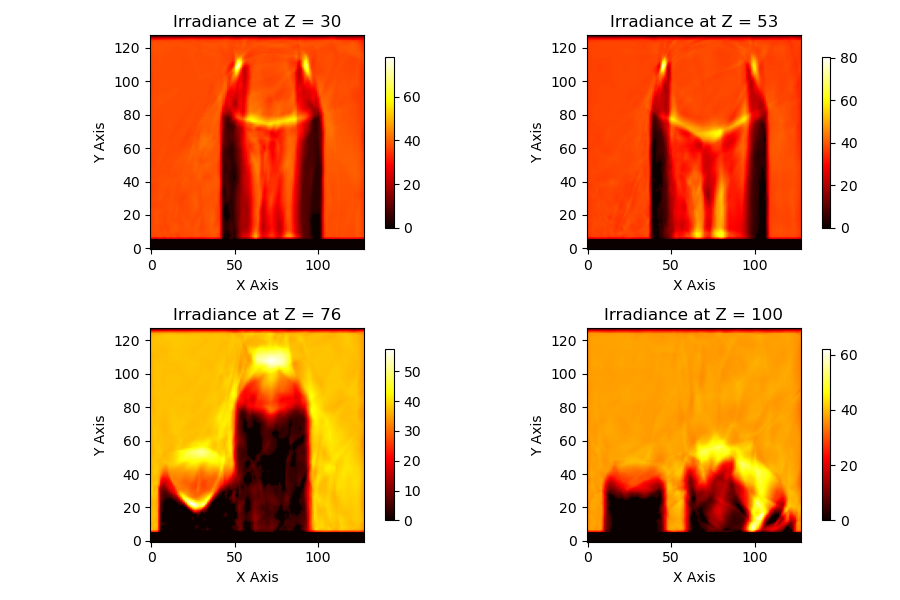

In [42]:
# Visualize the predicted irradiance field
predicted_irradiance = mlp.predict(pad=True)
plotter.plot_irradiance_slices(predicted_irradiance, threshold=3, 
                               num_slices=4, z_start=30, z_end=100)

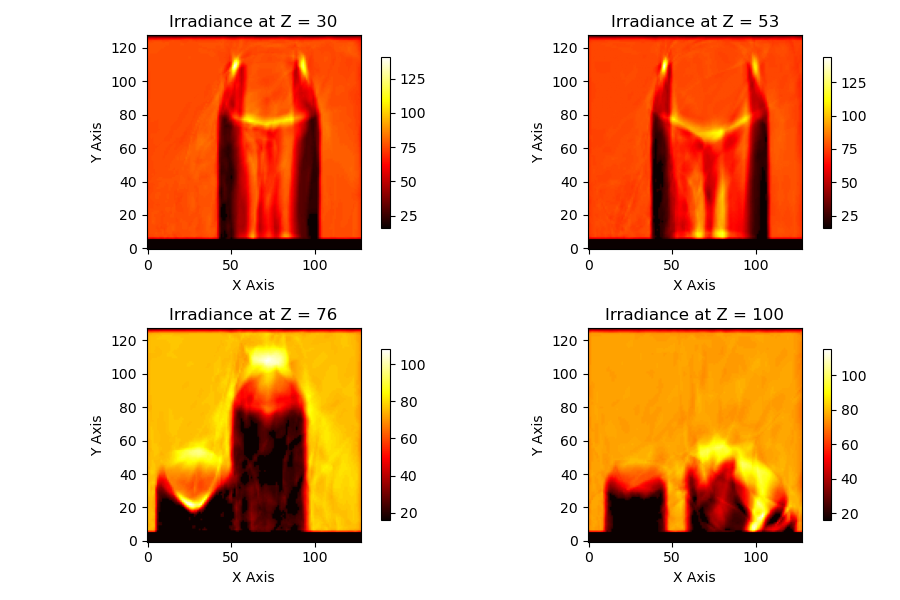

In [44]:
corrected_mlp_res = mlp_post_process(predicted_irradiance, None)
plotter.plot_irradiance_slices(corrected_mlp_res, threshold=3, num_slices=4, z_start=30, z_end=100)

### 4.3 Octree to store irradiance

Number of nodes: 235217
Octree Memory usage: 13172152 bytes
In comparison, NumPy Storage Usage: 8388608 bytes


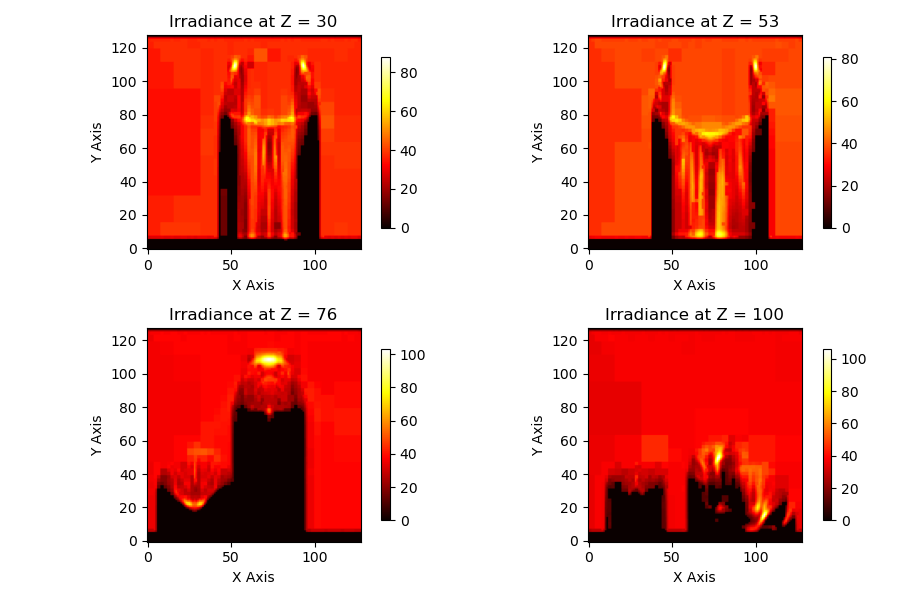

In [51]:
octree = Octree(threshold=12)
octree.construct(scene.irradiance)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {scene.irradiance.nbytes} bytes")
octree.visualize(plotter, num_slices=4, z_start=30, z_end=100)

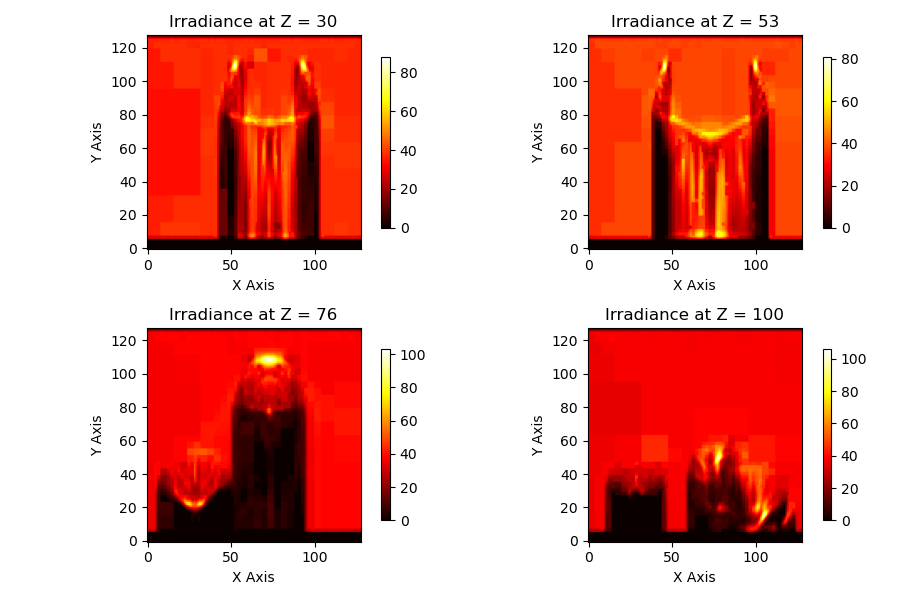

In [52]:
testor = octree.init_empty_grid()
octree.fill_grid(octree.root, testor, 0, 0, 0, octree.grid_size)
plotter.plot_irradiance_slices(testor, threshold=3, num_slices=4, z_start=30, z_end=100)

In [47]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

32.0